In [1]:
from models.vae_allhist_glm import VAE_AllHist_GLM, NN_Encoder

import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
Z_file = "spk_loc.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
Z = np.load(base_dir+cell_type+"_"+experiment+"/data/"+Z_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
Z = torch.from_numpy(Z)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

In [3]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 401
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 100000
iter_no = 5000
epoch_no = 15
layer_no = 3

In [4]:
Z_train = Z[:T_train].to(device).float()
Z_test = Z[T_train:T_train + T_test].to(device).float()
V_train = V[:T_train].to(device).float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float().to(device)
train_I_neural = I_neural[:T_train].float().to(device)
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
decoder = VAE_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)
encoder = NN_Encoder(C_syn_e, C_syn_i, T_no, layer_no, device)

enc_optimizer = torch.optim.Adam(encoder.parameters(), lr = 0.0001)
dec_optimizer = torch.optim.Adam(decoder.parameters(), lr = 0.002)

encoder.to(device).float()
decoder.to(device).float()
print(sum(p.numel() for p in encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in decoder.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

35440
114


In [6]:
P_prior = torch.ones(batch_size, sub_no-1).to(device) * 0.001
temp_list = [0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
temp_count = 0

t = torch.arange(100).to(device)
t_tau = t / 6
kern = t_tau * torch.exp(-t_tau) * 1.75
kern = torch.flip(kern, [0])

for i in tnrange(iter_no):
    encoder.train()
    decoder.train()
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    #if (i%500==0) & (temp_count < 14):
        #temp = temp_list[temp_count]
        #temp_count += 1
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size]
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size]
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    batch_Z = Z_train[batch_idx : batch_idx+batch_size]
    
    Z_enc, P_enc = encoder(batch_V, batch_E_neural, batch_I_neural)
    
    Z_enc_in = torch.zeros(batch_size, sub_no).to(device)
    Z_enc_in[:,0] = Z_enc_in[:,0] + batch_Z
    Z_enc_in[:,1:] = Z_enc_in[:,1:] + Z_enc
    
    P_dec, out_filters = decoder.train_forward(batch_E_neural, batch_I_neural, Z_enc_in)

    prior_loss = bce_criterion(P_enc , P_prior)
    hid_bern_loss = bce_criterion(P_dec[:,1:], P_enc.detach())
    vis_bern_loss = bce_criterion(P_dec[:,0], batch_Z)
        
    loss = prior_loss + hid_bern_loss + vis_bern_loss
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    if i%250 == 249:
        test_Z_dec, test_P_dec, test_out_filters = decoder.test_forward(test_E_neural, test_I_neural)
         
        test_bern_loss = bce_criterion(test_P_dec[:,0], Z_test)
        
        Z_pad = torch.zeros(99+T_test).to(device)
        Z_pad[-T_test:] = test_Z_dec[:,0]
        V_conv = F.conv1d(Z_pad.reshape(1,1,-1), kern.reshape(1,1,-1)).flatten()
        test_var = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=V_conv.cpu().detach().numpy())
        
        print(i, "VAR:", np.round(test_var , 6),
              "TEST BERN:", np.round(test_bern_loss.item(), 6),
              "TRAIN TOT:", np.round(torch.sum(Z_enc).item(), 6),
              "TRAIN HID:", np.round(hid_bern_loss.item(), 6), 
              "TRAIN PRIOR:", np.round(prior_loss.item(), 6))


<ipython-input-6-8a6e632d8228>:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


249 VAR: -4.548931 TEST BERN: 0.043024 TRAIN TOT: 5444.883301 TRAIN HID: 0.445608 TRAIN PRIOR: 0.018438
499 VAR: -2.328466 TEST BERN: 0.020475 TRAIN TOT: 17233.142578 TRAIN HID: 0.230693 TRAIN PRIOR: 0.038729
749 VAR: -1.530102 TEST BERN: 0.015146 TRAIN TOT: 17514.203125 TRAIN HID: 0.181808 TRAIN PRIOR: 0.039036
999 VAR: -0.844129 TEST BERN: 0.012092 TRAIN TOT: 15121.339844 TRAIN HID: 0.165743 TRAIN PRIOR: 0.034261
1249 VAR: -0.535516 TEST BERN: 0.011849 TRAIN TOT: 13828.318359 TRAIN HID: 0.15274 TRAIN PRIOR: 0.031707
1499 VAR: -0.417942 TEST BERN: 0.012387 TRAIN TOT: 10704.230469 TRAIN HID: 0.127565 TRAIN PRIOR: 0.025494
1749 VAR: -0.313519 TEST BERN: 0.012526 TRAIN TOT: 5860.777832 TRAIN HID: 0.077865 TRAIN PRIOR: 0.016424
1999 VAR: -0.29754 TEST BERN: 0.012854 TRAIN TOT: 3152.193848 TRAIN HID: 0.048675 TRAIN PRIOR: 0.011656
2249 VAR: -0.276794 TEST BERN: 0.012504 TRAIN TOT: 639.909912 TRAIN HID: 0.016923 TRAIN PRIOR: 0.008022
2499 VAR: -0.279024 TEST BERN: 0.012577 TRAIN TOT: 593.86

KeyboardInterrupt: 

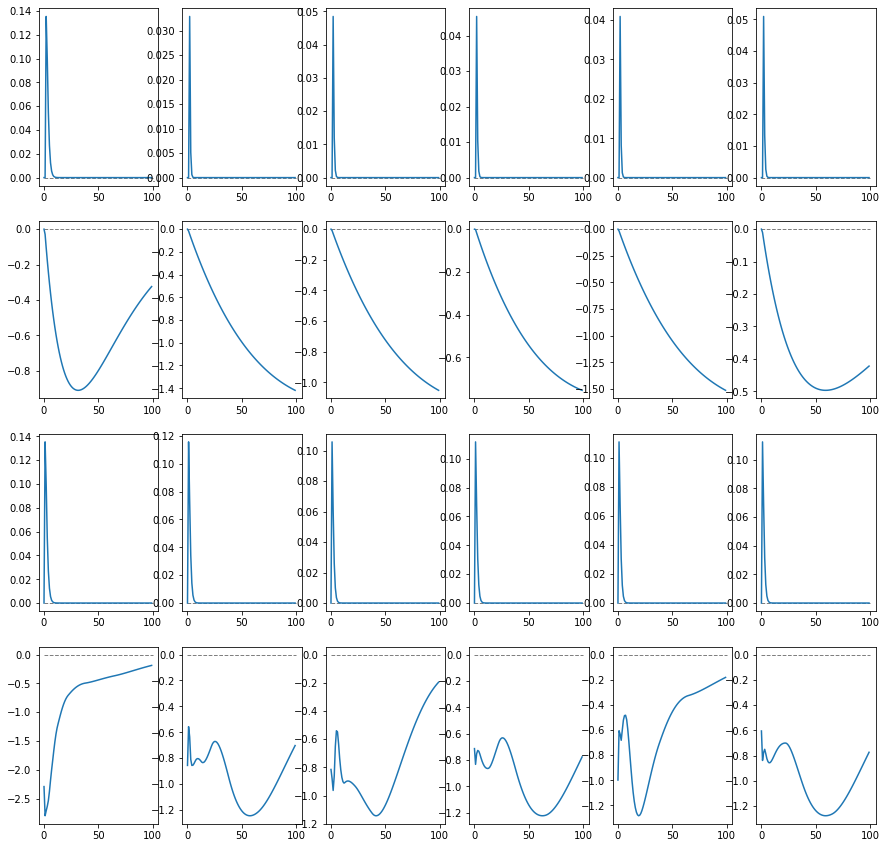

In [13]:
sub_no = 6
fig, axs = plt.subplots(nrows=4, ncols=sub_no, figsize=(15,15))
for row in range(4):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:100])
        axs[row,col].hlines(y=0,xmin=0,xmax=100, color="gray",linewidth=1,linestyle="--")

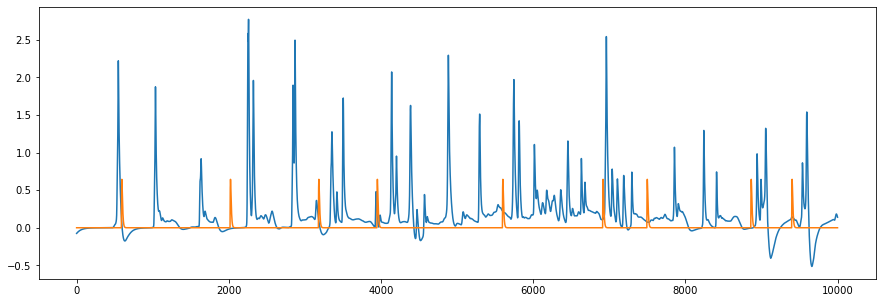

In [8]:
plt.figure(figsize=(15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(V_conv.cpu().detach().numpy()[16000:26000])

In [9]:
print(decoder.Tau_spk)

Parameter containing:
tensor([ 0.0000, -0.1465, -0.2237, -0.1767, -0.1804, -0.1705], device='cuda:0',
       requires_grad=True)


In [10]:
print(decoder.W_syn)

Parameter containing:
tensor([[-1.0000,  0.8078],
        [-1.8151,  1.4032],
        [-1.6837,  1.1183],
        [-1.7075,  0.7325],
        [-1.7391,  1.4725],
        [-1.6567,  0.1626]], device='cuda:0', requires_grad=True)


In [14]:
print(decoder.Tau_syn)

Parameter containing:
tensor([[ 0.0000,  3.5070],
        [-0.9529,  5.0029],
        [-0.7599,  5.0635],
        [-0.7808,  4.9430],
        [-0.8491,  5.0408],
        [-0.7122,  4.1834]], device='cuda:0', requires_grad=True)


In [12]:
print(decoder.W_hist)

Parameter containing:
tensor([[ 1.2674, -1.1976,  1.1535,  1.1880,  1.0020,  0.6880,  0.5480,  0.3654,
          0.4547],
        [ 0.8363,  0.5423,  0.2583, -0.8738,  0.3181,  0.8183,  0.4576,  0.5670,
         -1.0321],
        [ 0.8720,  0.2973,  0.8793, -0.5050, -0.2935,  0.9248, -0.0434, -0.9991,
         -0.5106],
        [-0.7006, -0.6504,  0.6070,  0.5722,  0.6392,  0.6714,  0.6318, -0.2964,
          1.0845],
        [-0.9732, -0.2885, -0.5845, -0.6702,  0.0128, -0.7185, -0.9608,  0.3299,
          0.5225],
        [-0.6548, -0.5829, -0.7173,  0.4111,  0.8131,  0.4302, -0.7086,  0.4315,
          1.0758]], device='cuda:0', requires_grad=True)
